In [19]:
import pandas as pd
import json, os
from pprint import pprint
import xmltodict
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random

In [2]:
def extract_info(file_path):
    """Loop through parent directory to find subdirectories that have xml data. Returns xml data converted to dict."""
    with open(file_path) as f:
        text = f.read()
        xml = xmltodict.parse(text)
        json_data = json.dumps(xml)
        data_dict = json.loads(json_data)
        
    return data_dict

In [3]:
# dict of lists to hold data from xml files
data = {'folder':[],
         'filename': [],
         'bndbox_xmin': [],
         'bndbox_xmax': [],
         'bndbox_ymin': [],
         'bndbox_ymax': [],
         'difficult': [],
         'breed': [],
         'pose': [],
         'truncated': [],
         'segment': [],
         'size_depth': [],
         'size_height': [],
         'size_width': [],
         'source': []}

In [4]:
# loop through directories and get image metadata
for breed in os.listdir('Annotation'):
    for example in os.listdir(f'Annotation/{breed}'):
        file_path = f'Annotation/{breed}/{example}'
        info = extract_info(file_path)
        
        # skip images with multiple dogs ~ about 3000 images will be skippped
        if type(info['annotation']['object']) == list:
            continue
            
        data['folder'].append(info['annotation']['folder'])
        data['filename'].append(info['annotation']['filename'])
        data['bndbox_xmin'].append(info['annotation']['object']['bndbox']['xmin'])
        data['bndbox_xmax'].append(info['annotation']['object']['bndbox']['xmax'])
        data['bndbox_ymin'].append(info['annotation']['object']['bndbox']['ymin'])
        data['bndbox_ymax'].append(info['annotation']['object']['bndbox']['ymax'])
        data['difficult'].append(info['annotation']['object']['difficult'])
        data['breed'].append(info['annotation']['object']['name'])
        data['pose'].append(info['annotation']['object']['pose'])
        data['truncated'].append(info['annotation']['object']['truncated'])
        data['segment'].append(info['annotation']['segment'])
        data['size_depth'].append(info['annotation']['size']['depth'])
        data['size_height'].append(info['annotation']['size']['height'])
        data['size_width'].append(info['annotation']['size']['width'])
        data['source'].append(info['annotation']['source']['database'])
        

In [5]:
# dict to df
metadata_df = pd.DataFrame.from_dict(data)

# convert select columns to numeric types
metadata_df[['bndbox_xmin','bndbox_xmax','bndbox_ymin','bndbox_ymax','difficult',
            'truncated','segment','size_depth','size_height','size_width']] =\
metadata_df[['bndbox_xmin','bndbox_xmax','bndbox_ymin','bndbox_ymax','difficult',
            'truncated','segment','size_depth','size_height','size_width']]\
            .apply(pd.to_numeric)

metadata_df['filename'] = metadata_df['filename'] + '.jpg'
metadata_df.head()

,folder,filename,bndbox_xmin,bndbox_xmax,bndbox_ymin,bndbox_ymax,difficult,breed,pose,truncated,segment,size_depth,size_height,size_width,source
0,02111500,n02111500_7006.jpg,6,294,0,495,0,Great_Pyrenees,Unspecified,0,0,3,500,297,ImageNet database
1,02111500,n02111500_287.jpg,0,479,0,278,0,Great_Pyrenees,Unspecified,0,0,3,333,500,ImageNet database
2,02111500,n02111500_2151.jpg,143,290,12,208,0,Great_Pyrenees,Unspecified,0,0,3,281,500,ImageNet database
3,02111500,n02111500_1777.jpg,154,499,75,373,0,Great_Pyrenees,Unspecified,0,0,3,375,500,ImageNet database
4,02111500,n02111500_4851.jpg,145,437,76,373,0,Great_Pyrenees,Unspecified,0,0,3,375,500,ImageNet database


In [6]:
metadata_df.describe()

,bndbox_xmin,bndbox_xmax,bndbox_ymin,bndbox_ymax,difficult,truncated,segment,size_depth,size_height,size_width
count,19222.000000,19222.000000,19222.000000,19222.000000,19222.0,19222.0,19222.0,19222.0,19222.000000,19222.000000
mean,72.603319,367.766986,53.883883,356.539434,0.0,0.0,0.0,3.0,386.932577,440.724690
std,71.112380,129.723418,57.645938,123.741637,0.0,0.0,0.0,0.0,126.486362,144.862589
min,0.000000,71.000000,0.000000,90.000000,0.0,0.0,0.0,3.0,100.000000,97.000000
25%,14.000000,294.000000,13.000000,292.000000,0.0,0.0,0.0,3.0,333.000000,360.000000
50%,54.500000,361.000000,37.000000,342.000000,0.0,0.0,0.0,3.0,375.000000,500.000000
75%,115.000000,439.000000,78.000000,405.000000,0.0,0.0,0.0,3.0,464.000000,500.000000
max,1230.000000,2735.000000,1548.000000,2457.000000,0.0,0.0,0.0,3.0,2562.000000,3264.000000


In [7]:
# resize images
def resize(infile, outfile, size=50):
    """Resize images"""
    image = Image.open(infile)
    new_image = image.resize((size, size))
    
    try:
        new_image.save(outfile)
    except OSError as e:
        os.remove(outfile)
        print(f'Skipping: {infile}')

In [8]:
%%time

cnt = 0
for directory in os.listdir('Images'):
    if directory == 'reshaped':
        print('Skipping reshaped')
        continue
    for file in os.listdir(f'Images/{directory}'):

        infile = f'Images/{directory}/{file}'
        outfile = f'Images/reshaped/{file}'
        try:
            resize(infile, outfile)
        except Exception as e:
            print(e)
            
        cnt +=1
        
print(cnt)

Skipping reshaped
Skipping: Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg
20580
CPU times: user 1min 25s, sys: 2.07 s, total: 1min 27s
Wall time: 1min 27s


In [12]:
# Get list of files that were successfully converted and have good metadata
usable_metadata = set(metadata_df['filename'])

usable_images = set(os.listdir('Images/reshaped'))

usable_files = usable_metadata.intersection(usable_images)

metadata_df = metadata_df[metadata_df['filename'].isin(usable_files)]
print(metadata_df.shape)

# delete unusable files from reshaped
for img in os.listdir('Images/reshaped'):
    if img not in usable_files:
        os.remove(f'Images/reshaped/{img}')

metadata_df.head()

(18644, 15)


,folder,filename,bndbox_xmin,bndbox_xmax,bndbox_ymin,bndbox_ymax,difficult,breed,pose,truncated,segment,size_depth,size_height,size_width,source
0,02111500,n02111500_7006.jpg,6,294,0,495,0,Great_Pyrenees,Unspecified,0,0,3,500,297,ImageNet database
1,02111500,n02111500_287.jpg,0,479,0,278,0,Great_Pyrenees,Unspecified,0,0,3,333,500,ImageNet database
2,02111500,n02111500_2151.jpg,143,290,12,208,0,Great_Pyrenees,Unspecified,0,0,3,281,500,ImageNet database
3,02111500,n02111500_1777.jpg,154,499,75,373,0,Great_Pyrenees,Unspecified,0,0,3,375,500,ImageNet database
4,02111500,n02111500_4851.jpg,145,437,76,373,0,Great_Pyrenees,Unspecified,0,0,3,375,500,ImageNet database


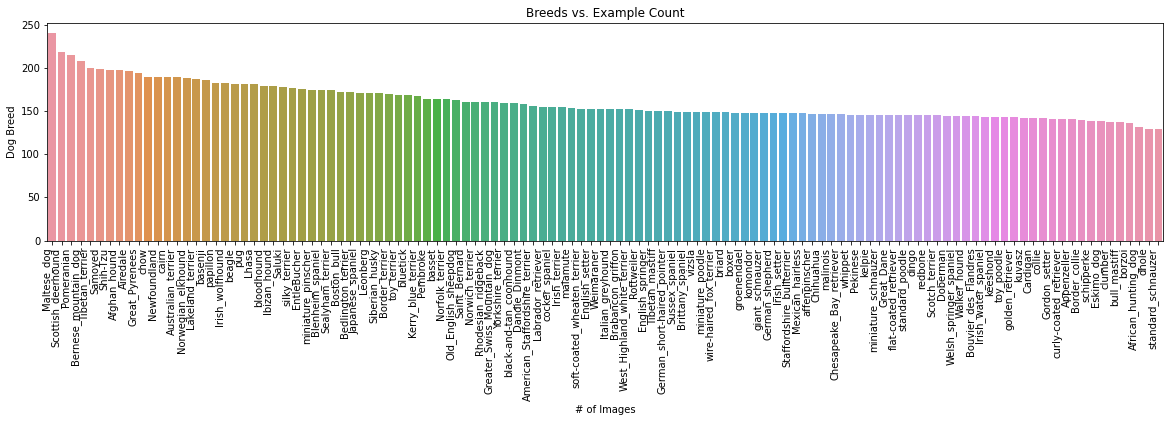

In [13]:
# plot the # of dogs in each class
class_counts = metadata_df['breed'].value_counts()

plt.figure(figsize=(20, 4))
examples = sns.barplot(x = class_counts.index, y =class_counts.values)
examples.set_title('Breeds vs. Example Count')
examples.set_xticklabels(examples.get_xticklabels(), rotation=90, ha="right")
examples.set(xlabel='# of Images', ylabel='Dog Breed')
# plt.tight_layout()
plt.show()

In [28]:
import torch